Import OCTIS (and optionally) BERTopic. Instructions can be found at the OCTIS github repository on setting up and basic features.

In [ ]:
!pip install octis
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 30.4 MB/s 
     |████████████████████████████████| 170 kB 62.4 MB/s 
     |████████████████████████████████| 16.5 MB 36.7 MB/s 
     |████████████████████████████████| 100 kB 9.5 MB/s 
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
     |████████████████████████████████| 22.3 MB 29.2 MB/s 
     |████████████████████████████████| 4.4 MB 39.1 MB/s 
     |████████████████████████████████| 1.2 MB 32.4 MB/s 
     |████████████████████████████████| 101 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233366 sha256=d3b75bf73fa043be242bd758d3c5d53dd2c3fe00fcc90edca77021c9b6f0b4ca
  Stored in directory: /root/.cache/pip/wh

Import OCTIS models, evaluation functions and optimizer. Also some basic essentials.

In [ ]:
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer

from octis.models.LDA import LDA
from octis.models.CTM import CTM
from octis.models.NeuralLDA import NeuralLDA
from octis.models.ProdLDA import ProdLDA
from octis.models.NMF import NMF
from octis.models.ETM import ETM
#from bertopic import BERTopic

import os
import string
from octis.preprocessing.preprocessing import Preprocessing

import pandas as pd
import numpy as np
import inspect
import matplotlib.pyplot as plt
import time

Can be ignored if not running in Colab

In [ ]:
# Run this to mount the Notebook in your Google Drive account 
from google.colab import drive
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A "hyperparameter" - how many words we want to consider from each topic.

In [ ]:
topK = 6

Creating our custom OCTIS dataset, using titles from our publications as the input list. The preprocessor takes care of preprocessing and creates a dictionary for us.

In [ ]:
os.chdir(os.path.pardir)

# Initialize preprocessing
preprocessor = Preprocessing(vocabulary=None, max_features=None,
                             remove_punctuation=True, punctuation=string.punctuation,
                             lemmatize=True, stopword_list='english',
                             min_chars=1, min_words_docs=0)
# preprocess
dataset = preprocessor.preprocess_dataset(documents_path=r'/content/drive/My Drive/nasa/OCTIS/titles.csv')

# save the preprocessed dataset
dataset.save('zot')

created vocab
4856


### Model #1 : LDA

Future models will follow the same structure:

#### - The first cell will optimize.

We set our search space of hyperparameters. 

We want to optimize coherence, specifically c_v because it has been stated to be most similar to human performance. NPMI would not be a bad option to consider either.

Optimization_runs and model_runs can also be set; the higher the better, but with diminishing returns.

Our training is saved to a file, but this is not necessary.


#### - The second cell shows topic coherence and diversity at each iteration.

#### - The third cell shows best set of hyperparameters, which is manually inputted to the evaluation notebook.


In [ ]:
#print(inspect.getsource(LDA))

In [ ]:
# LDA model
model = LDA()
# evaluation metric to train on
npmi = Coherence(texts=dataset.get_corpus(), topk=topK, measure='c_v')
div = TopicDiversity(topk=topK)

# hyperparams
search_space = {"alpha": Real(0.1, 0.9),
                "num_topics": Integer(25, 50)
}

# SET THESE PARAMETERS
# As a rule of thumb, if you have N hyperparameters to optimize, 
# then you should make at least 15 times N iterations.
optimization_runs=40
model_runs=6

# optimize
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=[div], # to keep track of other metrics
    save_path='/content/drive/My Drive/nasa/OCTIS/results/test_lda//')

optimization_result.save_to_csv("/content/drive/My Drive/nasa/OCTIS/results_lda.csv")

Current call:  0


Current call:  1


Current call:  2


Current call:  3


Current call:  4


Current call:  5


Current call:  6


Current call:  7


Current call:  8


Current call:  9


Current call:  10


Current call:  11


Current call:  12


Current call:  13


Current call:  14


Current call:  15


Current call:  16


Current call:  17


Current call:  18


Current call:  19


Current call:  20


Current call:  21


Current call:  22


Current call:  23


Current call:  24


Current call:  25


Current call:  26


Current call:  27


Current call:  28


Current call:  29


Current call:  30


Current call:  31


Current call:  32


Current call:  33


Current call:  34


Current call:  35


Current call:  36


Current call:  37


Current call:  38


Current call:  39


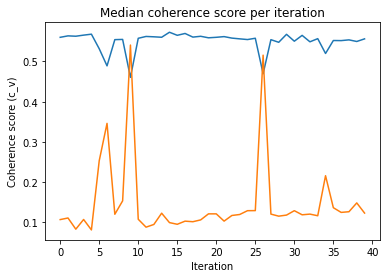

In [ ]:
lda_df = pd.read_csv("/content/drive/My Drive/nasa/OCTIS/results_lda.csv")
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(lda_df['Median(model_runs)'], label='topic coherence: c_v')
plt.plot(lda_df['Topic diversity(not optimized)'], label='topic diversity')
plt.show()

In [ ]:
# best result
best_lda_index = (lda_df['Median(model_runs)'] + lda_df['Topic diversity(not optimized)']).argmax()
print(best_lda_index)
# best parameter set
lda_df.iloc[best_lda_index, -4:]

9


Standard_Deviation(model_runs)    0.023664
alpha                             0.335145
num_topics                              45
Topic diversity(not optimized)    0.540741
Name: 9, dtype: object

### Model 2 : CTM

In [ ]:
#print(inspect.getsource(CTM))

In [ ]:
# CTM model
model = CTM(inference_type='zeroshot', 
            bert_model="bert-base-nli-mean-tokens",
            num_topics=45)
# evaluation metric to train on
npmi = Coherence(texts=dataset.get_corpus(), topk=topK, measure='c_v')
div = TopicDiversity(topk=topK)

# hyperparams
search_space = {"num_layers": Categorical({1, 2, 3}), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)
}

# SET THESE PARAMETERS
# As a rule of thumb, if you have N hyperparameters to optimize, 
# then you should make at least 15 times N iterations.
optimization_runs=100
model_runs=6

# optimize
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=[div], # to keep track of other metrics
    save_path='/content/drive/My Drive/nasa/OCTIS/results/test_ctm//')

optimization_result.save_to_csv("/content/drive/My Drive/nasa/OCTIS/results_ctm.csv")

Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29
Current call:  30
Current call:  31
Current call:  32
Current call:  33
Current call:  34
Current call:  35
Current call:  36
Current call:  37
Current call:  38
Current call:  39
Current call:  40
Current call:  41
Current call:  42
Current call:  43
Current call:  44
Current call:  45
Current call:  46
Current call:  47
Current call:  48
Current call:  49
Current call:  50
Current call:  51
Current call:  52
Current call:  53
Current call:  54
Current call:  55
Cu

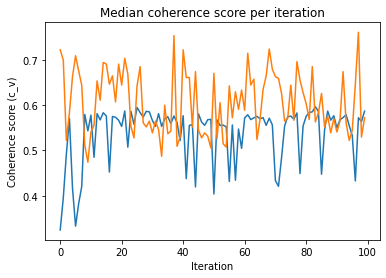

In [ ]:
ctm_df = pd.read_csv("/content/drive/My Drive/nasa/OCTIS/results_ctm.csv")
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(ctm_df['Median(model_runs)'], label='topic coherence: c_v')
plt.plot(ctm_df['Topic diversity(not optimized)'], label='topic diversity')
plt.show()

In [ ]:
# best result
best_ctm_index = (ctm_df['Median(model_runs)'] * 4 + ctm_df['Topic diversity(not optimized)']).argmax()
# best parameter set
print(best_ctm_index)
ctm_df.iloc[best_ctm_index, -5:]

37


activation                         sigmoid
dropout                           0.061557
num_layers                               1
num_neurons                            200
Topic diversity(not optimized)    0.753704
Name: 37, dtype: object

### Model 3 : Neural LDA

In [ ]:
# CTM model
model = NeuralLDA()
# evaluation metric to train on
npmi = Coherence(texts=dataset.get_corpus(), topk=topK, measure='c_v')
div = TopicDiversity(topk=topK)

# hyperparams
search_space = {"num_layers": Integer(1,3), 
                "num_neurons": Categorical({100, 200, 300}),
                "dropout": Real(0.0, 0.95),
                "num_topics": Integer(25, 50)}

# SET THESE PARAMETERS
# As a rule of thumb, if you have N hyperparameters to optimize, 
# then you should make at least 15 times N iterations.
optimization_runs=80
model_runs=6

# optimize
optimizer=Optimizer()

start = time.time()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=[div], # to keep track of other metrics
    save_path='/content/drive/My Drive/nasa/OCTIS/results/test_nda//')
end = time.time()
duration = end - start
print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

optimization_result.save_to_csv("/content/drive/My Drive/nasa/OCTIS/results_nda.csv")

Streaming output truncated to the last 5000 lines.
Early stopping
Current call:  34
Epoch: [1/100]	Samples: [2992/299200]	Train Loss: 116.36552894306693	Time: 0:00:00.267057
Epoch: [1/100]	Samples: [642/64200]	Validation Loss: 95.91133892499026	Time: 0:00:00.030136
Epoch: [2/100]	Samples: [5984/299200]	Train Loss: 111.94076456488135	Time: 0:00:00.261744
Epoch: [2/100]	Samples: [642/64200]	Validation Loss: 89.28527917594553	Time: 0:00:00.031696
Epoch: [3/100]	Samples: [8976/299200]	Train Loss: 109.1740818941657	Time: 0:00:00.256771
Epoch: [3/100]	Samples: [642/64200]	Validation Loss: 88.52505524061922	Time: 0:00:00.029948
Epoch: [4/100]	Samples: [11968/299200]	Train Loss: 106.53820555987842	Time: 0:00:00.273801
Epoch: [4/100]	Samples: [642/64200]	Validation Loss: 87.97485082988798	Time: 0:00:00.030619
Epoch: [5/100]	Samples: [14960/299200]	Train Loss: 104.58361522654161	Time: 0:00:00.257909
Epoch: [5/100]	Samples: [642/64200]	Validation Loss: 88.22149403889973	Time: 0:00:00.030124
Epoch

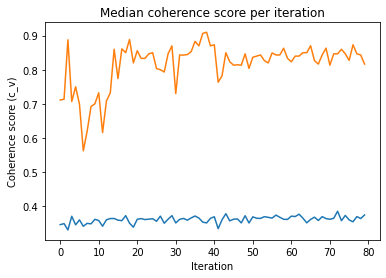

In [ ]:
nda_df = pd.read_csv("/content/drive/My Drive/nasa/OCTIS/results_nda.csv")
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(nda_df['Median(model_runs)'], label='topic coherence: c_v')
plt.plot(nda_df['Topic diversity(not optimized)'], label='topic diversity')
plt.show()

In [ ]:
# best result
best_nda_index = (nda_df['Median(model_runs)'] * 4 + nda_df['Topic diversity(not optimized)']).argmax()
# best parameter set
print(best_nda_index)
nda_df.iloc[best_nda_index, -5:]

72


dropout                           0.376287
num_layers                               1
num_neurons                            300
num_topics                              25
Topic diversity(not optimized)    0.846667
Name: 72, dtype: object

### Model 4 : ProdLDA

In [ ]:
#print(inspect.getsource(ETM))

In [ ]:
# CTM model
model = ProdLDA()
# evaluation metric to train on
npmi = Coherence(texts=dataset.get_corpus(), topk=topK, measure='c_v')
div = TopicDiversity(topk=topK)

# hyperparams
search_space = {"num_layers": Integer(1,3), 
                "num_neurons": Categorical({100, 200, 300}),
                "dropout": Real(0.0, 0.95),
                "num_topics": Integer(25, 50)}

# SET THESE PARAMETERS
# As a rule of thumb, if you have N hyperparameters to optimize, 
# then you should make at least 15 times N iterations.
optimization_runs=80
model_runs=6

# optimize
optimizer=Optimizer()

start = time.time()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=[div], # to keep track of other metrics
    save_path='/content/drive/My Drive/nasa/OCTIS/results/test_pda//')
end = time.time()
duration = end - start
print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

optimization_result.save_to_csv("/content/drive/My Drive/nasa/OCTIS/results_pda.csv")

Streaming output truncated to the last 5000 lines.
Epoch: [15/100]	Samples: [642/64200]	Validation Loss: 94.5792865456079	Time: 0:00:00.031822
Epoch: [16/100]	Samples: [47872/299200]	Train Loss: 97.95461791339405	Time: 0:00:00.284572
Epoch: [16/100]	Samples: [642/64200]	Validation Loss: 94.14507968700563	Time: 0:00:00.031634
Epoch: [17/100]	Samples: [50864/299200]	Train Loss: 97.58325766497117	Time: 0:00:00.284505
Epoch: [17/100]	Samples: [642/64200]	Validation Loss: 93.8803506060924	Time: 0:00:00.033581
Epoch: [18/100]	Samples: [53856/299200]	Train Loss: 97.23854383172836	Time: 0:00:00.275287
Epoch: [18/100]	Samples: [642/64200]	Validation Loss: 93.35478643019252	Time: 0:00:00.031345
Epoch: [19/100]	Samples: [56848/299200]	Train Loss: 96.9825738101082	Time: 0:00:00.277775
Epoch: [19/100]	Samples: [642/64200]	Validation Loss: 94.12380872114426	Time: 0:00:00.032308
Epoch: [20/100]	Samples: [59840/299200]	Train Loss: 96.70507681943516	Time: 0:00:00.280771
Epoch: [20/100]	Samples: [642/64

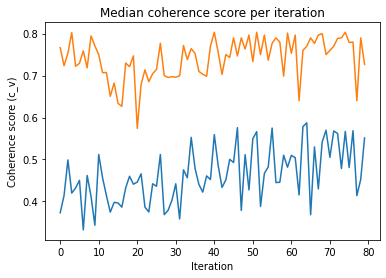

In [ ]:
pda_df = pd.read_csv("/content/drive/My Drive/nasa/OCTIS/results_pda.csv")
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(pda_df['Median(model_runs)'], label='topic coherence: c_v')
plt.plot(pda_df['Topic diversity(not optimized)'], label='topic diversity')
plt.show()

In [ ]:
# best result
best_pda_index = (pda_df['Median(model_runs)'] * 2 + pda_df['Topic diversity(not optimized)']).argmax()
print(best_pda_index)
# best parameter set
pda_df.iloc[best_pda_index, -5:]

64


dropout                           0.221017
num_layers                               2
num_neurons                            300
num_topics                              25
Topic diversity(not optimized)        0.77
Name: 64, dtype: object